# Test our method on the NLTT proper motion catalog

In [17]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform, normal
from scipy.optimize import newton
from scipy import stats
from astropy.table import Table
import corner
from scipy.interpolate import interp1d, interp2d
from scipy.stats import gaussian_kde

%matplotlib inline

In [18]:
# Read in sample from Tycho-2 table

filename = ('../data/rNLTT/catalog_tabs.dat')
#t = Table.read(filename, format='ascii.fixed_width_no_header', guess=True)
t = Table.read(filename, format='ascii', guess=True)

In [19]:
# Global variable
mu_kde = None
binary_kde = None

In [20]:
print t.colnames
print len(t['ra'])

['NLTT', 'ra', 'dec', 'mu_ra', 'mu_dec', 'mu_ra_err', 'mu_dec_err', 'V', 'B', 'R', 'J', 'H', 'K']
36085


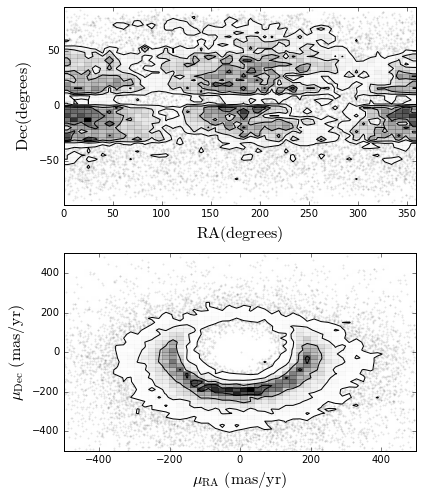

In [21]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

contourf_kwargs = {'bins':50}
corner.hist2d(t['ra'], t['dec'], range=[(0,360),(-90,90)], ax=ax[0], **contourf_kwargs)
#plt.scatter(t['ra'], t['dec'], marker='.', alpha=0.1)
ax[0].set_xlim(0,360)
ax[0].set_ylim(-90,90)
ax[0].set_xlabel(r'${\rm RA (degrees)}$', size=16)
ax[0].set_ylabel(r'${\rm Dec (degrees)}$', size=16)

contourf_kwargs = {'bins':50}
corner.hist2d(t['mu_ra']*1.0e3, t['mu_dec']*1.0e3, range=[(-500,500),(-500,500)], ax=ax[1], **contourf_kwargs)
#corner.hist2d(t['mu_ra']*1.0e3*np.cos(t['dec']*np.pi/180.0), t['mu_dec']*1.0e3, range=[(-500,500),(-500,500)], ax=ax[1], **contourf_kwargs)
#plt.scatter(t['mu_ra'], t['mu_dec'], marker='.', alpha=0.1)
ax[1].set_xlabel(r'$\mu_{\rm RA}\ {\rm (mas/yr)}$', size=16)
ax[1].set_ylabel(r'$\mu_{\rm Dec}\ {\rm (mas/yr)}$', size=16)
ax[1].set_xlim(-500,500)
ax[1].set_ylim(-500,500)

#plt.axes().set_aspect('equal')
plt.tight_layout()
#plt.savefig('../figures/rNLTT_pos_mu.pdf')
plt.show()

### Set minimum proper motion uncertainties to 1 mas/yr

In [22]:
min_t = 1.0e-3*np.ones(len(t))
tmp_t_ra = np.max((min_t, t['mu_ra_err']), axis=0)
tmp_t_dec = np.max((min_t, t['mu_dec_err']), axis=0)

t['mu_ra_err'] = tmp_t_ra
t['mu_dec_err'] = tmp_t_dec

In [23]:
def deg_to_rad(theta):
    """ Convert from degrees to radians """
    return np.pi * theta / 180.0

def rad_to_deg(theta):
    """ Convert from radians to degrees """
    return 180.0 * theta / np.pi

def get_theta_proj_degree(ra, dec, ra_b, dec_b):
    """ Return angular distance between two points

    Parameters
    ----------
    ra : float64
        Right ascension of first coordinate (degrees)
    dec : float64
        Declination of first coordinate (degrees)
    ra_b : float64
        Right ascension of second coordinate (degrees)
    dec_b : float64
        Declination of second coordinate (degrees)

    Returns
    -------
    theta : float64
        Angular distance (degrees)
    """

    ra1 = deg_to_rad(ra)
    dec1 = deg_to_rad(dec)
    ra2 = deg_to_rad(ra_b)
    dec2 = deg_to_rad(dec_b)

    dist = np.sqrt((ra1-ra2)**2 * np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)

    return rad_to_deg(dist)


def get_delta_mu(mu_ra, mu_dec, mu_ra_b, mu_dec_b):
    """ Return proper motion difference between two points

    Parameters
    ----------
    mu_ra : float64
        Proper motion in RA of first object (asec/yr)
    mu_dec : float64
        Proper motion in Dec of first object (asec/yr)
    mu_ra_b : float64
        Proper motion in RA of second object (asec/yr)
    mu_dec_b : float64
        Proper motion in Dec of second object (asec/yr)

    Returns
    -------
    delta_mu : float64
        proper motion difference (asec/yr)
    """

    delta_mu = np.sqrt((mu_ra-mu_ra_b)**2 + (mu_dec-mu_dec_b)**2)

    return delta_mu




def nstars_nearby(ra, dec, radius=1.0, catalog=None):
    """ This function searches the catalog for all stars
    within some input radius.
        
    Arguments
    ---------
    ra, dec : float
        Search coordinate (degrees)
    radius : float
        Search radius (degrees)
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    nstars : float
        Number of stars within given radius around input
        coordinate
    """
    
    if catalog is None: 
        print "You must supply an input catalog"
        return
    
    
    ra_rad1 = deg_to_rad(ra)
    dec_rad1 = deg_to_rad(dec)
    ra_rad2 = deg_to_rad(catalog['ra'])
    dec_rad2 = deg_to_rad(catalog['dec'])
    
    dist = rad_to_deg(np.sqrt((ra_rad1-ra_rad2)**2 * np.cos(dec_rad1)*np.cos(dec_rad2) + (dec_rad1-dec_rad2)**2))

    return len(np.where(dist<radius)[0])


def get_local_density(ra, dec, catalog=None):
    """ This function calculates the local stellar density
    
    Parameters
    ----------
    ra, dec : float
        Coordinates to find the local stellar density
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    rho_star : float
        Local density of stars per square degree
    """
    
    # Estimate number density of stars from number of systems within 5 degrees
    rad = 5.0
    rho_star = (nstars_nearby(ra, dec, radius=rad, catalog=t)-1) / (4.0*np.pi* rad**2)

    return rho_star
    

def get_random_alignment_P_pos(ra1, dec1, ra2, dec2, density=None, catalog=None):
    """ This function determines the probability of two 
    positions to be formed from simple random draws.
    Still need to check math
    
    Arguments
    ---------
    ra1, dec1 : float
        The first star's coordinates
    ra2, dec2 : float
        The second star's coordinates
    
    Returns
    -------
    P(pos) : float
        The probability, due to random alignments of randomly
        forming two stars with the given positions
    """


    # Catalog check
    if catalog is None: 
        print "You must provide a catalog"
        return
    
    # Projected distance
    theta = rad_to_deg(get_theta_proj_degree(ra1, dec1, ra2, dec2))
    
    # Local stellar density, if not provided
    if density is None:
        density = get_local_density(ra1, dec1, catalog=catalog)
    
    # P(pos)
    P_pos = 2.0*np.pi*theta * density
    
    return P_pos
    

In [24]:


def get_P_mu(mu_ra, mu_dec, catalog=None, method='kde'):
    """ This function calculates the probability of a 
    random star having the observed proper motion
    
    Parameters
    ----------
    mu_ra, mu_dec : float
        Proper Motion likelihood to calculate
    catalog : structure
        Catalog to search through
    method : string
        Method to perform 2D interpolation (options:kde)
        
    Returns
    -------
    P(mu) : float
        Probability of the proper motion
    """

    # Catalog check
    if catalog is None: 
        print "You must include a catalog."
        return


    # To Do: employ a 2D histogram, with a greedy binning algorithm to calculate P(mu)
#     # P(mu_ra)
#     vals, edges = np.histogram(t["mu_ra"], bins=nbins, normed=True, range=(mu_low, mu_high))
#     bin_width = edges[1]-edges[0]
#     bins = np.copy((edges[:-1]+0.5*bin_width))
#     P_mu_ra = interp1d(bins, vals, bounds_error=False, fill_value=0.0)

#     # P(mu_dec)
#     vals, edges = np.histogram(t["mu_dec"], bins=nbins, normed=True, range=(mu_low, mu_high))
#     bin_width = edges[1]-edges[0]
#     bins = np.copy((edges[:-1]+0.5*bin_width))
#     P_mu_dec = interp1d(bins, vals, bounds_error=False, fill_value=0.0)
    
#    return P_mu_ra(mu_ra) * P_mu_dec(mu_dec)

    if method is 'kde':
        # Use a Gaussian KDE
        global mu_kde
        if mu_kde is None: mu_kde = gaussian_kde((t["mu_ra"], t["mu_dec"]))
        P_mu = mu_kde.evaluate((mu_ra, mu_dec))
    else: 
        print "You must input an appropriate method."
        print "Options: 'kde' only"
        return
        
    return P_mu

In [25]:
def nstars_nearby_mu(mu_ra, mu_dec, radius=1.0, catalog=None):
    """ This function searches the catalog for all stars
    within some input proper motion radius.
        
    Arguments
    ---------
    mu_ra, mu_dec : float
        Search coordinate (asec/yr)
    radius : float
        Search radius (asec/yr)
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    nstars : float
        Number of stars within given proper motion radius around input
        coordinate
    """
    
    if catalog is None: 
        print "You must supply an input catalog"
        return
    
    dist = np.sqrt((mu_ra-catalog['mu_ra'])**2 + (mu_dec-catalog['mu_dec'])**2)

    return len(np.where(dist<radius)[0])

In [26]:
def get_random_alignment_P_mu(mu_ra1, mu_dec1, mu_ra2, mu_dec2, density=None, catalog=None):
    """ Unperfected!!!
    This function determines the probability of two proper
    motions to be formed from simple random draws
    
    Arguments
    ---------
    mu_ra1, mu_dec1 : float
        The first star's proper motion
    mu_ra2, mu_dec2 : float
        The second star's proper motion
    
    Returns
    -------
    P(mu) : float
        The probability, due to random alignments of randomly
        forming two stars with the given proper motion
    """
    
    # Catalog check
    if catalog is None: 
        print "You must include a catalog."
        return

    
    # Proper motion difference in degrees/yr
    delta_mu = rad_to_deg(get_theta_proj_degree(mu_ra1/3600.0, mu_dec1/3600.0, mu_ra2/3600.0, mu_dec2/3600.0))
    
    mu_ra_avg = (mu_ra1 + mu_ra2)/2.0
    mu_dec_avg = (mu_dec1 + mu_dec2)/2.0
    
    # density = get_P_mu(mu_ra2, mu_dec2, catalog=t, method='kde')
    if density is None:
        density = get_P_mu(mu_ra1, mu_dec1, catalog=t, method='kde')
    
    P_mu = 2.0*np.pi*delta_mu * density

    return P_mu

### We can now determine P(data | random alignment)

In [27]:
def get_P_random_alignment(ra1, dec1, ra2, dec2, mu_ra1, mu_dec1, mu_ra2, mu_dec2, 
                           pos_density=None, pm_density=None, catalog=None):
    """ This function calculates the probability of a 
    pair of stars being formed due to random alignments.
    
    Parameters
    ----------
    ra1, dec1 : float
        Coordinates of the first star
    ra2, dec2 : float
        Coordinates of the second star
    mu_ra1, mu_dec1 : float
        Proper motion of the first star
    mu_ra2, mu_dec2 : float
        Proper motion of the second star
    catalog : structure
        Catalog to search through
        
    Returns
    -------
    P(data) : float
        Probability that the pair was produced randomly
    """

    # Catalog check
    if catalog is None:
        print "Must provide a catalog"
        return
    
    # P(pos)
    if pos_density is None:
        P_pos = get_random_alignment_P_pos(ra1, dec1, ra2, dec2, catalog=catalog)
    else: 
        P_pos = get_random_alignment_P_pos(ra1, dec1, ra2, dec2, 
                                           density=pos_density, catalog=catalog)
        
    # P(mu)
    if pm_density is None:
        P_mu = get_random_alignment_P_mu(mu_ra1, mu_dec1, mu_ra2, mu_dec2, catalog=catalog)
    else:
        P_mu = get_random_alignment_P_mu(mu_ra1, mu_dec1, mu_ra2, mu_dec2, 
                                         density=pm_density, catalog=catalog)
    
    # So long as probabilities are independent:
    # P(pos,mu) = P(pos) * P(mu)
    P_pos_mu = P_pos * P_mu
    
    return P_pos_mu
    

### Check density distribution

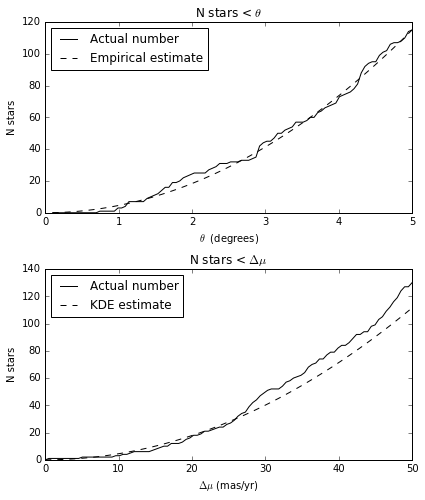

In [29]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

i=3344


# Position panel
ra_in = t['ra'][i]
dec_in = t['dec'][i] 
#print ra_in, dec_in

radius = np.linspace(0.1, 5.0, 100)
nstars = np.zeros(100)
for j in np.arange(100):
    r = radius[j]
    nstars[j] = nstars_nearby(ra_in, dec_in, radius=r, catalog=t)-1
ax[0].plot(radius, nstars, color='k', label='Actual number')

# Compare to density estimate derived from a 5 degree radius
r = 5.0
n_stars_near = nstars_nearby(ra_in, dec_in, radius=r, catalog=t)-1
n_density = n_stars_near / (4.0*np.pi*r**2)
y = (4.0*np.pi)*n_density*radius**2
ax[0].plot(radius,y, color='k', linestyle='--', label='Empirical estimate')

ax[0].set_title(r'N stars < $\theta$')
ax[0].set_xlabel(r'$\theta\ $ (degrees)')
ax[0].set_ylabel('N stars')
ax[0].legend(loc=2)




# Proper motion panel
mu_ra_in = t['mu_ra'][i]
mu_dec_in = t['mu_dec'][i] 

pm_density = get_P_mu(mu_ra_in, mu_dec_in, catalog=t, method='kde')
delta_mu = np.linspace(0.0, 0.05, 100)
P_mu = 4.0*np.pi*delta_mu**2*pm_density

N_stars = np.zeros(100)
for i in np.arange(100):
    N_stars[i] = nstars_nearby_mu(mu_ra_in, mu_dec_in, delta_mu[i], catalog=t)

ax[1].plot(delta_mu*1.0e3, N_stars, color='k', label='Actual number')


norm_factor = mu_kde.factor*len(t['ra'])
ax[1].plot(delta_mu*1.0e3, P_mu*norm_factor, color='k', linestyle='--', label='KDE estimate')

ax[1].set_xlim(0.0,50.0)

ax[1].set_title(r'N stars < $\Delta \mu$')
ax[1].set_xlabel(r'$\Delta \mu$ (mas/yr)')
ax[1].set_ylabel('N stars')

ax[1].legend(loc=2)


plt.tight_layout()
#plt.savefig('../figures/rNLTT_local_density.pdf')
plt.show()

### Check proper motion distribution

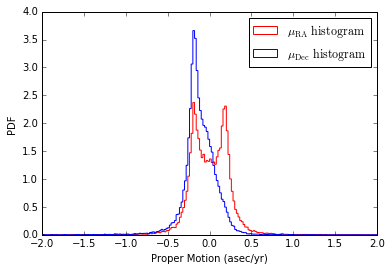

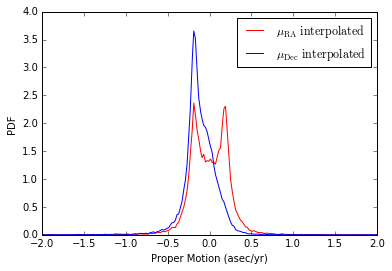

In [30]:
nbins = 200
mu_low, mu_high = -2.0, 2.0



# Histogram plot

# Plot histograms of data
plt.hist(t["mu_ra"], color='r', histtype='step', bins=nbins, range=(mu_low, mu_high), label=r'$\mu_{\rm RA}\ {\rm histogram}$', normed=True)
plt.hist(t["mu_dec"], color='b', histtype='step', bins=nbins, range=(mu_low, mu_high), label=r'$\mu_{\rm Dec}\ {\rm histogram}$', normed=True)

plt.ylabel('PDF')
plt.xlabel('Proper Motion (asec/yr)')

plt.legend()

plt.show()

# Interpolation plot

# P(mu_ra)
vals, edges = np.histogram(t["mu_ra"], bins=nbins, normed=True, range=(mu_low, mu_high))
bin_width = edges[1]-edges[0]
bins = np.copy((edges[:-1]+0.5*bin_width))
P_mu_ra = interp1d(bins, vals, bounds_error=False, fill_value=0.0)

# P(mu_dec)
vals, edges = np.histogram(t["mu_dec"], bins=nbins, normed=True, range=(mu_low, mu_high))
bin_width = edges[1]-edges[0]
bins = np.copy((edges[:-1]+0.5*bin_width))
P_mu_dec = interp1d(bins, vals, bounds_error=False, fill_value=0.0)

# Plot
x_test = np.linspace(-2.0, 2.0, 2000)
plt.plot(x_test, P_mu_ra(x_test), color='r', label=r'$\mu_{\rm RA}\ {\rm interpolated}$')
plt.plot(x_test, P_mu_dec(x_test), color='b', label=r'$\mu_{\rm Dec}\ {\rm interpolated}$')

plt.ylabel('PDF')
plt.xlabel('Proper Motion (asec/yr)')

plt.legend()

plt.show()

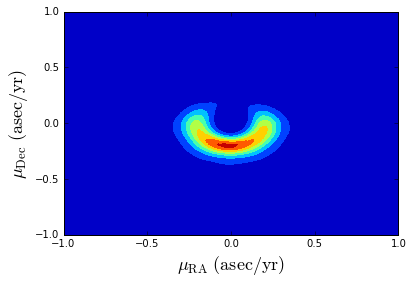

In [31]:
# Test 100 points
mu_x = np.linspace(-1.0, 1.0, 100)
mu_y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(mu_x, mu_y)



# # Evaluate each point using gaussian KDE algorithm
# Z = mu_kde.evaluate((X.flatten(), Y.flatten()))

# # Plot resulting distribution
# plt.tricontourf(X.flatten(), Y.flatten(), Z)

# plt.xlabel(r"$\mu_{\rm RA}$", size=18)
# plt.ylabel(r"$\mu_{\rm Dec}$", size=18)

# plt.show()



# Evaluate using greedy binning
Z = get_P_mu(X.flatten(), Y.flatten(), catalog=t)

# Plot resulting distribution
plt.tricontourf(X.flatten(), Y.flatten(), Z)

plt.xlabel(r"$\mu_{\rm RA}\ {\rm (asec/yr)}$", size=18)
plt.ylabel(r"$\mu_{\rm Dec}\ {\rm (asec/yr)}$", size=18)

plt.show()



## Probability due to true binaries

### Constants

In [32]:
GGG = 6.674e-8             # Gravitational constant in cgs
alpha = -2.35              # IMF index
day_to_sec = 3600.0*24.0   # Sec in day
Rsun_to_cm = 6.995e10      # Rsun to cm
Msun_to_g = 1.989e33       # Msun to g
AU_to_cm = 1.496e13        # AU to cm
pc_to_cm = 3.086e18        # pc to cm

### Get random binary variates

In [33]:
# M1 is from power law: M^alpha
def get_M1(M_low=0.5, M_high=10.0, num_sys=1):
    C_m = 1.0 / (M_high**(alpha+1.0) - M_low**(alpha+1.0))
    tmp_y = uniform(size=num_sys)
    
    return (tmp_y/C_m + M_low**(alpha+1.0))**(1.0/(alpha+1.0))

# M2 is flat in q-space
def get_M2(M1, num_sys=1):
    return M1*uniform(size=num_sys)
    
# a is from inverse: a^-1
def get_a(a_low=1.0e4, a_high=1.0e6, num_sys=1):
    C_a = 1.0 / (np.log(a_high) - np.log(a_low))
    tmp_y = uniform(size=num_sys)
    
    return a_low*np.exp(tmp_y/C_a)

# e from thermal distribution
def get_e(num_sys=1):
    """ Return e from thermal distribution """
    return np.sqrt(uniform(size=num_sys))

### Get random orientation deviates

In [34]:
# Mean anomaly
def get_M(num_sys=1):
    return 2.0 * np.pi * uniform(size = num_sys)

# inclination angle
def get_inc(num_sys=1):
    return np.arccos(1.0-2.0*uniform(size = num_sys))

# argument of periapse
def get_omega(num_sys=1):
    return 2.0*np.pi*uniform(size = num_sys)

# longitude of the ascending node
def get_Omega(num_sys=1):
    return 2.0*np.pi*uniform(size = num_sys)

### Binary functions

In [35]:
def P_to_a(M1, M2, P):
    """ Orbital period (days) to separation (Rsun) """
    mu = GGG * (M1 + M2) * Msun_to_g
    n = 2.0*np.pi / P / day_to_sec
    return np.power(mu/(n*n), 1.0/3.0) / Rsun_to_cm

def a_to_P(M1, M2, a):
    """ Orbital separation (Rsun) to period (days) """
    mu = GGG * (M1 + M2) * Msun_to_g
    n = np.sqrt(mu/(a**3 * Rsun_to_cm**3))
    return 2.0*np.pi / n / day_to_sec

# Function to get the true anomaly
def get_f(M, e):
    
    # Get eccentric anomaly
    def func_E(x,M,e):
        return M - x + e*np.sin(x)
    
    E = newton(func_E, 0.5, args=(M,e))

    # Get true anomaly from eccentric anomaly
    f = np.arccos((np.cos(E)-e)/(1.0-e*np.cos(E)))
    if np.sin(E) < 0:
        f = 2.0*np.pi - f            
    
    return f

def get_proj_sep(f, e, sep, Omega, omega, inc):
    sep_x = sep*(np.cos(Omega)*np.sin(omega+f) + np.sin(Omega)*np.cos(omega+f)*np.cos(inc))
    sep_y = sep*(np.cos(Omega)*np.cos(omega+f) - np.sin(Omega)*np.sin(omega+f)*np.cos(inc))
    proj_sep = np.sqrt(sep_x**2 + sep_y**2)

    return proj_sep


def get_pm(f, e, a, P, Omega, omega, inc):
    r_dot = a * e * np.sin(f) / np.sqrt(1.0 - e*e) * (2.0*np.pi/P)
    r_f_dot = a / np.sqrt(1.0 - e*e) * (1.0 + e*np.cos(f)) * (2.0*np.pi/P)
    pm_1 = r_dot * (np.cos(Omega)*np.cos(omega+f) - np.sin(Omega)*np.sin(omega+f)*np.cos(inc))
    pm_2 = r_f_dot * (np.cos(Omega)*np.sin(omega+f) + np.sin(Omega)*np.cos(omega+f)*np.cos(inc))
    pm = np.sqrt(pm_1**2 + pm_2**2) / 1.0e5

    return pm

### Generate random binaries

In [36]:
num_sys = 1000000

M1 = get_M1(num_sys=num_sys)
M2 = get_M2(M1, num_sys=num_sys)
a = get_a(num_sys=num_sys)
e = get_e(num_sys=num_sys)
M = get_M(num_sys)
inc = get_inc(num_sys)
omega = get_omega(num_sys)
Omega = get_Omega(num_sys)

In [37]:
# Calculate f's
f = np.zeros(num_sys)
for i in np.arange(num_sys):
    f[i] = get_f(M[i], e[i])
    
# Calculate separations - in Rsun
sep = a * (1.0 - e*e) / (1.0 + e*np.cos(f)) 
proj_sep = get_proj_sep(f, e, sep, Omega, omega, inc)

# Orbital period in days
P = a_to_P(M1, M2, a)
# Calculate proper motions
pm = get_pm(f, e, a*Rsun_to_cm, P*day_to_sec, Omega, omega, inc)


# Save ang sep, proper motion difference at 100 pc distance
dist = 100.0
theta_100 = (proj_sep*Rsun_to_cm)/(dist * pc_to_cm) * (180.0 * 3600.0 / np.pi)
delta_pm_100 = (pm * 1.0e5)/(dist * pc_to_cm) * (1.0e3 * 180.0 * 3600.0 / np.pi) * day_to_sec*365.25
b = np.zeros(num_sys, dtype=[('theta','>f4'), ('delta_mu','>f4')])

for i in np.arange(num_sys):
    b['theta'][i] = theta_100[i]
    b['delta_mu'][i] = delta_pm_100[i]
    

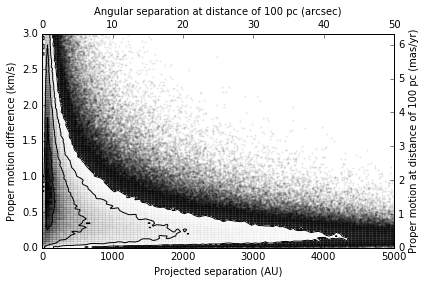

In [38]:
fig, ax1 = plt.subplots(1,1, figsize=(6,4))

xmin, xmax = 0.0, 5000.0
ymin, ymax = 0.0, 3.0

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

ax1.set_xlabel("Projected separation (AU)")
ax1.set_ylabel("Proper motion difference (km/s)")


contourf_kwargs = {'bins':100}
corner.hist2d(proj_sep*Rsun_to_cm/AU_to_cm, pm, nbins=100, range=([xmin,xmax],[ymin,ymax]), **contourf_kwargs)

ax2 = ax1.twiny()
xticks = np.linspace(xmin,xmax,6)
angles = (xticks * AU_to_cm)/(100.0 * pc_to_cm) * (180.0 * 3600.0 / np.pi)
ax2.set_xticks(angles)
ax2.set_xlabel('Angular separation at distance of 100 pc (arcsec)')


ax3 = ax1.twinx()
yticks = np.linspace(ymin, ymax, 7)
def pm_at_100pc(pm):
    return (pm * 1.0e5)/(100.0 * pc_to_cm) * (1.0e3 * 180.0 * 3600.0 / np.pi) * day_to_sec*365.25

ax3.set_ylim(0.0, pm_at_100pc(ax1.get_ylim()[1]))
ax3.set_ylabel('Proper motion at distance of 100 pc (mas/yr)')

plt.tight_layout()
#plt.savefig('../figures/theta_mu.pdf', rasterized=True)
plt.show()

In [39]:
def get_P_binary(theta, delta_mu, sim_binaries=b, method='kde'):
    """ This function calculates the probability of a 
    random star having the observed proper motion
    
    Parameters
    ----------
    theta : float
        Angular distance between two stars
    delta_mu : float
        Proper Motion difference between two stars
    sim_binaries : structure
        Set of simulated binaries search through
    method : string
        Method to perform 2D interpolation (options:kde)
        
    Returns
    -------
    P(theta, delta_mu) : float
        Probability that angular separation, pm separation
        is due to a genuine binary
    """

    # Catalog check
    if sim_binaries is None: 
        print "You must include a set of simulated binaries."
        return

    if method is 'kde':
        # Use a Gaussian KDE
        global binary_kde
        if binary_kde is None: binary_kde = gaussian_kde((sim_binaries["theta"], sim_binaries["delta_mu"]))
            
        # TEST
        values = np.vstack([theta*np.ones(len(delta_mu)), delta_mu])
#        P_binary = binary_kde.evaluate((theta, delta_mu))
        P_binary = binary_kde.evaluate(values)
        
    else: 
        print "You must input an appropriate method."
        print "Options: 'kde' only"
        return
        
    return P_binary

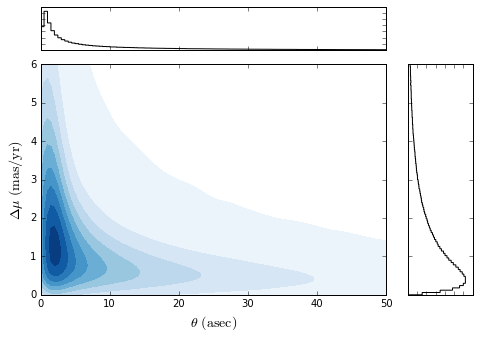

In [40]:
fig = plt.figure()

ax1 = fig.add_axes([0.0, 0.0, 0.8, 0.8])
ax2 = fig.add_axes([0.0, 0.85, 0.8, 0.15])
ax3 = fig.add_axes([0.85, 0.0, 0.15, 0.8])


# Main plot
theta_test = np.linspace(0.0, 50.0, 100)
delta_mu_test = np.linspace(0.0, 6.0, 100)
X, Y = np.meshgrid(theta_test, delta_mu_test)

Z = get_P_binary(X.flatten(), Y.flatten(), sim_binaries=b)

levels = np.linspace(0.0001, 0.03, 10)
ax1.tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels, extend='max')

ax1.set_xlabel(r"$\theta\ ({\rm asec})$", fontsize=14)
ax1.set_ylabel(r"$\Delta \mu\ ({\rm mas/yr})$", fontsize=14)


# Theta histogram
ax2.hist(b["theta"], histtype='step', bins=100, color='k', range=[0.0, 50.0])
ax2.set_xticklabels([])
ax2.set_yticklabels([])


# Delta mu histogram
ax3.hist(b["delta_mu"], histtype='step', bins=100, color='k', range=[0.0, 6.0], orientation=u'horizontal')
ax3.set_xticklabels([])
ax3.set_yticklabels([])

plt.show()

In [45]:
# Test with the first star in the catalog
i = 45

star1 = t['ra'][i], t['dec'][i], t['mu_ra'][i], t['mu_dec'][i], t['mu_ra_err'][i], t['mu_dec_err'][i]

# Random alignment local densities
pos_density = get_local_density(star1[0], star1[1], catalog=t)
pm_density = get_P_mu(star1[2], star1[3], catalog=t, method='kde')

prob = np.zeros(len(t)-i-1)
#for j in np.arange(len(t)-i-1)+i+1:
for j in np.arange(4)+i+1:

    star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]

    if t['NLTT'][i] == t['NLTT'][j]:
        P_random = 1000.0
        continue
    else:
        # Random alignment probability
        P_random = get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3], 
                                          pos_density=pos_density, pm_density=pm_density,
                                          catalog=t)

    # Binary probability
    theta = get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
    delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2) * 1.0e3
    delta_mu_err = np.sqrt(star1[4]**2 + star1[5]**2 + star2[4]**2 + star2[5]**2) * 1.0e3
    if theta > 3600.0:
        P_binary = 0.0
    else:
        delta_mu_sample = normal(loc=delta_mu, scale=delta_mu_err, size=100)
        P_binary = 1.0/100 * np.sum(get_P_binary(theta, delta_mu_sample, sim_binaries=b))
    
    print star1[2]-star2[2], star1[3]-star2[3]
#    prob[j] = P_binary
    print t['NLTT'][i], t['NLTT'][j], P_binary, P_random, theta, delta_mu, delta_mu_err

-0.064199999 -0.1702000013
77 78 0.0 [ 149.21722158] 380639.455902 181.905690714 8.00936946332
-0.060100004 0.0394000002
77 80 0.0 [ 8.01599799] 51759.4966646 71.863554717 5.70350776032
-0.073899999 0.0051000007
77 82 0.0 [ 31.12631443] 194981.164512 74.0757710681 8.00936946332


### Now, let's calculate probability of random alignment for a few stars

In [219]:
#length = len(t)
length = 200
print "We are testing", len(t), "stars..."

dtype = [('i_1','i4'),('i_2','i4'),('NLTT_1','i4'),('NLTT_2','i4'),('P_random','f8'),('P_binary','f8')]
prob_out = np.zeros(length, dtype=dtype)

for i in np.arange(length):
    
    if i%100 == 0: print i
    
    star1 = t['ra'][i], t['dec'][i], t['mu_ra'][i], t['mu_dec'][i], t['mu_ra_err'][i], t['mu_dec_err'][i]

    # Random Alignment
    pos_density = get_local_density(star1[0], star1[1], catalog=t)
    pm_density = get_P_mu(star1[2], star1[3], catalog=t, method='kde')

    # To Do: Select only potential companion stars within 1 degree as possible pairs
    
    prob = np.zeros(len(t)-i-1)
    for j in np.arange(len(t)-i-1)+i+1:

        if t['NLTT'][i] == t['NLTT'][j]:
            prob[j-i-1] = 1000.0
            continue
            
        star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]
        
        P_random = get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3], 
                                          pos_density=pos_density, pm_density=pm_density,
                                          catalog=t)

        prob[j-i-1] = P_random
        
    # Binary probability for best matching pair
    j = np.argmin(prob)+i+1
    star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]
    theta = get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
    delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2) * 1.0e3
    delta_mu_err = np.sqrt(star1[4]**2 + star1[5]**2 + star2[4]**2 + star2[5]**2) * 1.0e3
    if theta > 3600.0:
        P_binary = 0.0
    else:
        delta_mu_sample = normal(loc=delta_mu, scale=delta_mu_err, size=100)
        P_binary = 1.0/100 * np.sum(get_P_binary(theta, delta_mu_sample, sim_binaries=b))

    prob_out['i_1'][i] = i
    prob_out['i_2'][i] = j
    prob_out['NLTT_1'][i] = t['NLTT'][i]
    prob_out['NLTT_2'][i] = t['NLTT'][j]
    prob_out['P_random'][i] = prob[j-i-1]
    prob_out['P_binary'][i] = P_binary
    # print i, np.argmin(prob)+i+1, prob[np.argmin(prob)]
    
print "... finished"

We are testing 36085 stars...
0
100


KeyboardInterrupt: 

In [217]:
print prob_out[prob_out['P_binary']>0.0]

[(35, 36, 53, 54, 0.0, 0.0022502554322221015)
 (45, 46, 77, 77, 0.0, 0.008273171418168367)
 (51, 53, 84, 86, 0.001449407406833558, 0.0001696153644465904)
 (100, 101, 158, 159, 0.0, 0.004521757755427117)
 (110, 111, 172, 173, 0.0, 0.0028585655024039535)
 (113, 114, 175, 176, 6.553825322267908e-05, 0.00024304502698762343)
 (127, 128, 195, 196, 0.0007979584488936911, 0.0005420183600766684)
 (137, 138, 213, 213, 0.0, 0.009660831015999018)
 (157, 158, 239, 240, 0.0, 0.0025468992306428985)
 (190, 191, 295, 296, 0.0, 0.0012169342860982478)]


In [116]:
#print prob_out[0:38]

for i in np.arange(200):
    print i, t['NLTT'][prob_out[i][0]], t['NLTT'][prob_out[i][1]], prob_out[i][2]

0 2 3 0.0898635149468
1 3 2503 2.64032663562
2 4 1271 0.158521466773
3 5 58772 0.177553781713
4 6 105 1.27880627169
5 7 361 2.2479138609
6 8 2469 0.0893095158939
7 9 87 0.187386191944
8 10 53 0.126723123764
9 11 125 1.0617427055
10 13 50 0.16291241081
11 17 45 0.462057969979
12 18 275 0.43871554335
13 20 1475 0.663765627384
14 21 4829 1.42592676648
15 22 412 0.30727433509
16 24 316 0.478619095373
17 25 58817 0.265611546644
18 29 33595 0.810109942036
19 30 60 0.10774650863
20 32 231 2.41603577232
21 33 38 1.94367048705
22 35 627 0.492984090177
23 36 155 0.888863475426
24 37 511 1.90307844338
25 38 170 1.37917581045
26 40 1429 2.08820281635
27 42 58759 1.57478128578
28 43 125 0.756004141414
29 45 58785 0.0572457178232
30 47 3187 0.306661933485
31 48 1109 0.471674530909
32 50 9184 2.1928553379
33 51 198 0.568850062739
34 52 1973 4.48845033282
35 53 54 0.0
36 54 163 1.40716417589
37 55 58771 0.132236080869
38 57 259 2.39080004363
39 60 4554 0.966988058975
40 61 1051 0.533901461146
41 65 10

In [121]:
print t['NLTT'][142]

217


708 32.9041676198


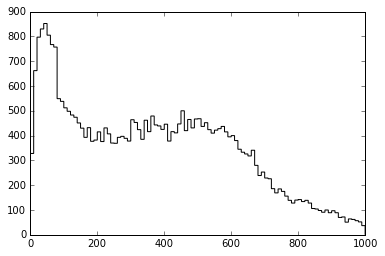

In [56]:
print np.argmin(prob), prob[i]

plt.hist(prob, histtype='step', color='k', bins=100, range=(0.0, 1000.0))
plt.show()

In [52]:
print prob[0]

0.0
